# Gathering data

## Header

In [ ]:
#header of imports
import matplotlib.pyplot as plt
import numpy as np
import astrometry
from scipy import stats
from scipy.optimize import curve_fit

from astropy.io import fits
from astropy.wcs import WCS

from photutils.detection import DAOStarFinder
from astropy.stats import mad_std

from astropy.stats import sigma_clipped_stats
from astropy.stats import SigmaClip

from astropy import units as u
from photutils.background import Background2D, MedianBackground
from photutils.aperture import aperture_photometry, CircularAperture

import astropy as ap

solver = astrometry.Solver(
    astrometry.series_5200.index_files(
        cache_directory="astrometry_cache",
        scales={1,3},
    )
)

import logging
!pip install astroalign
from reproject import reproject_interp
from collections import defaultdict
from scipy.ndimage import shift as ndi_shift
from astropy.coordinates import SkyCoord, match_coordinates_sky

from astropy.visualization import PercentileInterval, AsinhStretch, ImageNormalize
import astroalign as aa
%matplotlib inline
#sets astroalign parameters
aa.MIN_MATCHES_FRACTION = 0.6
aa.NUM_NEAREST_NEIGHBORS = 10
aa.PIXEL_TOL = 3.0

## Functions

In [ ]:
#defining a function that corrects the bias:
def BiasCorrection(filenum):
    #Defining bias_image
    filename = 'bias.fits'
    hdu = fits.open(filename)[0]
    bias_image = hdu.data
    hdr = hdu.header

    #create a dictionary for the corrected files
    corrected = {}

    #loops over the range filenum
    for i in range(1, filenum+1):
        filename = f'23feb.{i:04d}.fits'
        hdu = fits.open(filename)[0]
        image = hdu.data
        hdr = hdu.header
        
        #subtract and store in dictionary
        bias = image - bias_image
        filt = hdr.get('FILTER')
        exposure = hdr.get('EXPTIME')
        corrected[filename] = {
        'data': bias,
        'filter': filt,
        'exposure': exposure,
        'img': hdu
        }

    #returns the dictionary
    return corrected

In [ ]:
#Defining function that flatfields:
def Flatfielding(corrected):
    #create a dictionary of the filters
    flatdict = {
        'Harris-R': 'rflat.fits',
        'Harris-V': 'vflat.fits',
        'Harris-B': 'bflat.fits',
        'Bessell-U': 'uflat.fits',
    }
    #interate across dict
    for file, info in corrected.items():
        data = info['data']
        filt = info['filter']
        #grab flat field fits
        flat = flatdict.get(filt)

        hdu = fits.open(flat)[0]
        flatdata = hdu.data

        #adds flatdata to our dict
        info['flatdata'] = data / flatdata
    #returns the dict
    return corrected

In [ ]:
#Defining function that finds background
def Background(corrected):
    #loops over each file and grabs their info
    for file, info in corrected.items():
        #grabs the flatdata
        image = info['flatdata']
        
        #fits background
        mean, median, std = sigma_clipped_stats(image, sigma=3.0)
        sigma_clip = SigmaClip(sigma=3.0)
        bkg_estimator = MedianBackground()
        bkg = Background2D(image, (50, 50), filter_size=(3,3),sigma_clip=sigma_clip,bkg_estimator=bkg_estimator)
        
        #Subtracts background
        image = image - bkg.background
        #adds background to dict
        info['bgsub'] = image
    #returns dict
    return corrected

In [ ]:
#Defining function that finds stars:
def Starfinding(corrected):
    #blank dictionary for star data
    tables = {}

    #loops through each file in dict and grabs their info
    for file, info in corrected.items():
        #workbook 6 stuff
        image = info['flatdata']
        
        bkg_sigma = mad_std(image)

        daofind = DAOStarFinder(fwhm=4.0, threshold=100.0 * bkg_sigma)

        sources = daofind(image)

        for col in sources.colnames:
            sources[col].info.format = '%.8g' 
            
        sources = sources[sources['ycentroid'] >= 1]
        positions = np.transpose((sources['xcentroid'], sources['ycentroid']))

        radii = [3.0, 4.0, 5.0,7.0,10.0,15.0,25.0,40.0]

        apertures = [CircularAperture(positions, r=r) for r in radii]
        
        phot_table = aperture_photometry(image, apertures)
        #adds tables to the dictionary
        tables[file] = phot_table
    #returns a dict of phot_tables, and radii if necessary
    return tables, radii

In [ ]:
#Define astropy function
def astropy(groups):
    #workbook 7 stuff
    logging.getLogger().setLevel(logging.INFO)
    unit = 'pix'
    #loops over each filter and grabs their files
    for filt, files in groups.items():
        #loops over each file and grabs their info
        for file, info in files.items():
            #workbook 7 stuff
            x = info['position'][0]
            y = info['position'][1]
            stars = [(x[i], y[i]) for i in range(0,len(x))]
            solution = solver.solve(
                stars=stars,
                size_hint=None,
                position_hint=astrometry.PositionHint(
                    ra_deg=114.73,
                    dec_deg=38,
                    radius_deg=1.0),
        solution_parameters=astrometry.SolutionParameters(),
)    
            if solution.has_match():
                #adds wcs to dict
                info['wcs'] = solution.best_match().astropy_wcs()
    #returns the dict
    return groups

In [ ]:
#stacking
def Stack(filt):
    #setting up a reference image
    ref_file, first_info = next(iter(filt.items()))
    ref_wcs   = first_info['wcs']
    ref_shape = first_info['flatdata'].shape
    img_aligned = first_info['flatdata']
    ref_flat = img_aligned
    aligned_images = [img_aligned]
    #loops through all files and aligns
    for  files, file in filt.items():
        img = file['flatdata']
        img_aligned, _ = aa.register(ref_flat, img, detection_sigma=2.0)
        aligned_images.append(img_aligned)
    #stacks the images
    stacked = np.median(aligned_images, axis=0)
    #returns the image
    return stacked

In [ ]:
#half life radius
def hlr(image, x0, y0):
    #pixel coords
    y, x = np.indices(image.shape)
    #distance from center
    r = np.hypot(x - x0, y - y0)
    #radial step
    dr = 1.0

    #masks left half of image
    mask = (x <= x0)

    #set radii and get cumflux for left half
    #set radii max to 1400 to get whole image which is slightly larger than needed but its fine like this
    radii = np.arange(0, 1400, dr)
    cumflux = np.array([np.nansum(image[(r <= rad) & mask]) for rad in radii])
    
    #get total and half flux
    total_flux = cumflux[-1]
    half_flux = total_flux / 2.0

    #finds where cumflux >= half_flux
    idx = np.searchsorted(cumflux, half_flux)
    #grabs radii at idx value
    R_half = radii[idx]

    #plot
    plt.figure(figsize=(6,4))
    plt.plot(radii, cumflux, 'o-', label='Curve of Growth')
    plt.axvline(R_half, color='red', linestyle='--', label=f'R₁/₂ = {R_half:.1f} px')
    plt.xlabel("Radius (pixels)")
    plt.ylabel("Cumulative Flux")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    #returns value for half light radius
    return R_half

In [11]:
#mass
def mass(r_half):
    #arcsec/pix
    plate_scale = 0.15
    # distance to cluster in pc
    distance   = 88500
    #grab half life
    r_pix = r_half
    
    # convert to arcsec
    r_arcsec = r_pix * plate_scale
    # convert to radians
    r_rad = (r_arcsec * u.arcsec).to(u.rad).value
    # physical radius (pc)
    r_pc = distance * r_rad
    
    #G in  pc·(km/s)^2 / M_sun
    G = 4.302e-3
    
    #physical half-light radius in pc
    hlr_pc = r_pc
    # km/s, e.g. from spectra
    sigma = 3.7
    
    #Wolf et al. mass estimator
    M_half = 4 * sigma**2 * hlr_pc / G
    M_full = 2.0 * M_half    
    print(f"M_1/2 = {M_half:.2e} M_sun")
    print(f"M_1/2*2 = {M_half*2.0:.2e} M_sun")

    return M_full

## Running Code

In [12]:
#running some code
#bias correction dict
corrected = BiasCorrection(56)
#flatfielding dict
corrected = Flatfielding(corrected)
#grabs tables and radii from starfinding
tables, radii = Starfinding(corrected)

In [40]:
#group starfinding info with files and files with filters
groups = {
        'Harris-R': {},
        'Harris-V': {},
        'Harris-B': {},
        'Bessell-U': {}
    }
#goes over each file in dict and adds to appropriate filter with info
for file, info in corrected.items():
        filt = info['filter']
        tbl = tables[file]
        x = tbl['xcenter'].value    
        y = tbl['ycenter'].value  
        if filt == 'Harris-R':
            groups[filt][file] = info
        elif filt == 'Harris-V':
            groups[filt][file] = info
        elif filt == 'Harris-B':
            groups[filt][file] = info
        elif filt == 'Bessell-U':
            groups[filt][file] = info
        groups[filt][file]['position']=[x,y]

In [41]:
#LONG CODE RUNS ASTROPY FOR EACH FILE AND STORES WCS (runs for like 5 mins)
groups = astropy(groups)

INFO:root:solve 1: start
INFO:root:solve 1: slice=[0, 25) (1 / 1), index="5200/index-5201-05.fits" (1 / 2)
INFO:root:solve 1: logodds=142.777, matches=25, conflicts=0, distractors=3, ra=114.538, dec=38.8879, scale=0.425611, index="5200/index-5201-05.fits"
INFO:root:solve 1: logodds=143.271, matches=25, conflicts=0, distractors=3, ra=114.538, dec=38.8879, scale=0.424874, index="5200/index-5201-05.fits"
INFO:root:solve 1: logodds=134.66, matches=24, conflicts=0, distractors=4, ra=114.538, dec=38.8881, scale=0.428704, index="5200/index-5201-05.fits"
INFO:root:solve 1: logodds=144.971, matches=25, conflicts=0, distractors=3, ra=114.538, dec=38.8883, scale=0.42792, index="5200/index-5201-05.fits"
INFO:root:solve 1: logodds=151.965, matches=25, conflicts=0, distractors=3, ra=114.538, dec=38.888, scale=0.425242, index="5200/index-5201-05.fits"
INFO:root:solve 1: logodds=148.687, matches=25, conflicts=0, distractors=3, ra=114.538, dec=38.888, scale=0.427714, index="5200/index-5201-05.fits"
INF

starting HR stack
starting HB stack
starting HV stack
starting BU stack


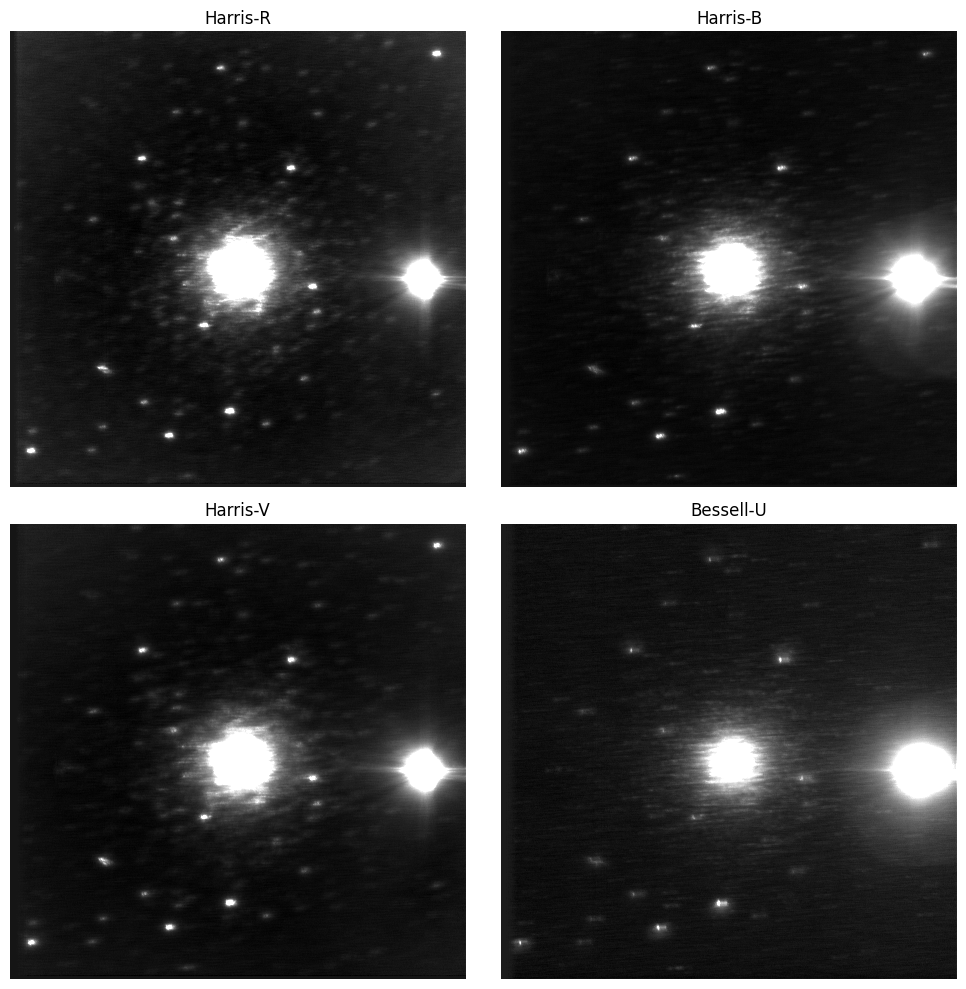

In [42]:
#stacks images for each filter takes a while
print("starting HR stack")
HR = Stack(groups['Harris-R'])
print("starting HB stack")
HB = Stack(groups['Harris-B'])
print("starting HV stack")
HV = Stack(groups['Harris-V'])
print("starting BU stack")
BU = Stack(groups['Bessell-U'])

#creates a dict with the stacked images
stacks = {
    'Harris-R': {'flatdata': HR},
    'Harris-B': {'flatdata': HB},
    'Harris-V': {'flatdata': HV},
    'Bessell-U': {'flatdata': BU}
}

# Compute vmin and vmax and normalizes
Rvmin, Rvmax = np.percentile(HR, (2, 98))
Rnorm = ImageNormalize(vmin=Rvmin, vmax=Rvmax)
Bvmin, Bvmax = np.percentile(HB, (2, 98))
Bnorm = ImageNormalize(vmin=Bvmin, vmax=Bvmax)
Vvmin, Vvmax = np.percentile(HV, (2, 98))
Vnorm = ImageNormalize(vmin=Vvmin, vmax=Vvmax)
Uvmin, Uvmax = np.percentile(BU, (2, 98))
Unorm = ImageNormalize(vmin=Uvmin, vmax=Uvmax)

#graphs
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].imshow(HR, cmap='gray', norm=Rnorm, origin='lower')
axes[0, 0].set_title("Harris-R")
axes[0, 0].axis('off')

axes[0, 1].imshow(HB, cmap='gray', norm=Bnorm, origin='lower')
axes[0, 1].set_title("Harris-B")
axes[0, 1].axis('off')

axes[1, 0].imshow(HV, cmap='gray', norm=Vnorm, origin='lower')
axes[1, 0].set_title("Harris-V")
axes[1, 0].axis('off')

axes[1, 1].imshow(BU, cmap='gray', norm=Unorm, origin='lower')
axes[1, 1].set_title("Bessell-U")
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

Harris-R


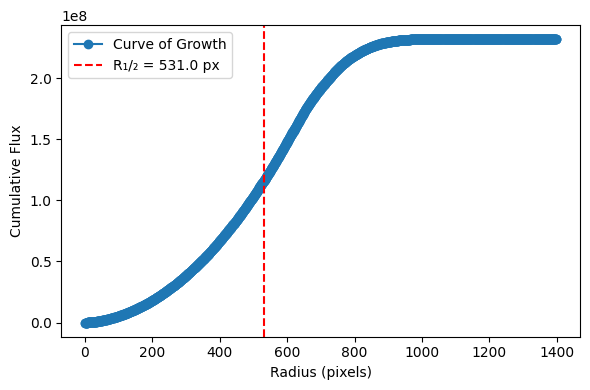

Half-light radius: 531.0 pixels

Harris-B


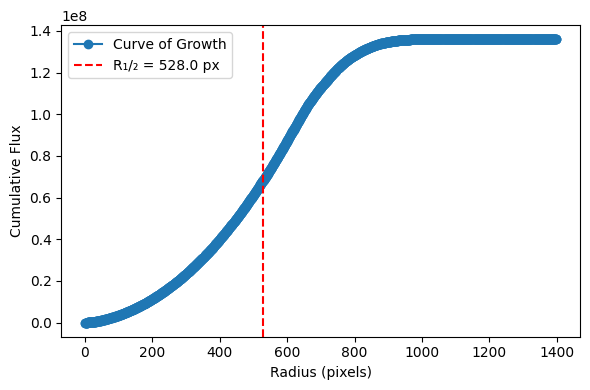

Half-light radius: 528.0 pixels

Harris-V


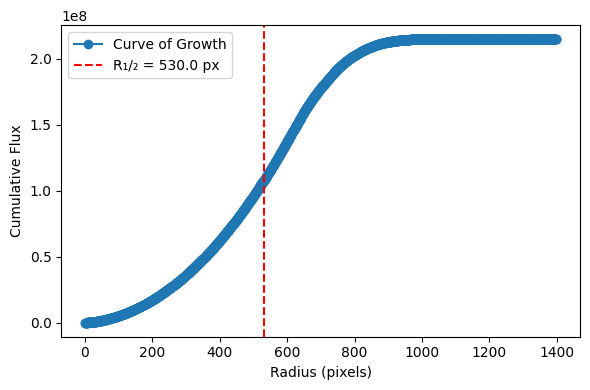

Half-light radius: 530.0 pixels

Bessel-U


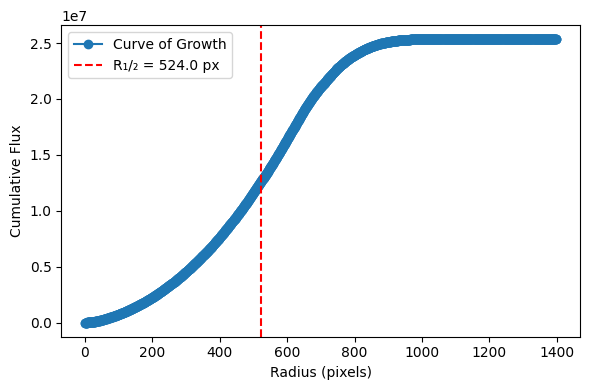

Half-light radius: 524.0 pixels


In [53]:
#x0 and y0 was determined manually and is about the center of the cluster
#determines HLR and graphs
print("Harris-R")
Rhalf = hlr(HR, x0=650, y0=620)
print(f"Half-light radius: {Rhalf:.1f} pixels")
print()
print("Harris-B")
Bhalf = hlr(HB, x0=650, y0=620)
print(f"Half-light radius: {Bhalf:.1f} pixels")
print()
print("Harris-V")
Vhalf = hlr(HV, x0=650, y0=620)
print(f"Half-light radius: {Vhalf:.1f} pixels")
print()
print("Bessel-U")
Uhalf = hlr(BU, x0=650, y0=620)
print(f"Half-light radius: {Uhalf:.1f} pixels")

In [52]:
#calculates mass and prints
print("Harris-R")
MR = mass(Rhalf)
print("Harris-B")
BR = mass(Bhalf)
print("Harris-V")
VR = mass(Vhalf)
print("Bessel-U")
UR = mass(Uhalf) 

Harris-R
M_1/2 = 4.35e+05 M_sun
M_1/2*2 = 8.70e+05 M_sun
Harris-B
M_1/2 = 4.33e+05 M_sun
M_1/2*2 = 8.65e+05 M_sun
Harris-V
M_1/2 = 4.34e+05 M_sun
M_1/2*2 = 8.68e+05 M_sun
Bessel-U
M_1/2 = 4.29e+05 M_sun
M_1/2*2 = 8.59e+05 M_sun


In [45]:
#preps a dict for a complete stack with all filters
allfiles = {}
for filt, files in groups.items():
    for file, info in files.items():
        allfiles[file] = info

In [46]:
#stacks, Takes a while (took me like 8 minutes
final = Stack(allfiles)

(-0.5, 1364.5, -0.5, 1364.5)

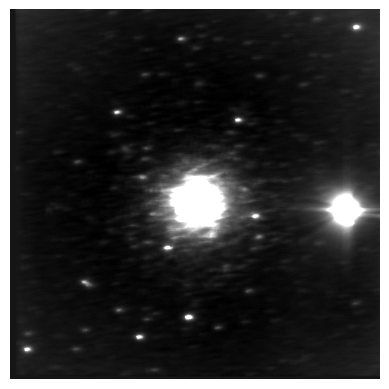

In [49]:
#graph stacked img
Fvmin, Fvmax = np.percentile(final, (2, 98))
Fnorm = ImageNormalize(vmin=Fvmin, vmax=Fvmax)

#graphs
plt.subplots()

plt.imshow(final, cmap='gray', norm=Fnorm, origin='lower')
plt.axis('off')

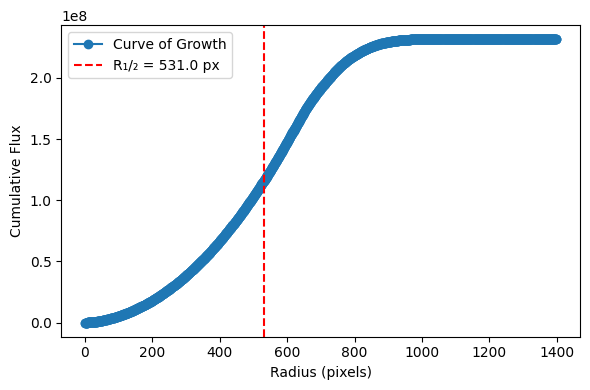

In [50]:
#combined half life
finalr = hlr(final, x0=650, y0=620)

In [51]:
#combined mass
Mf = mass(finalr)

M_1/2 = 4.35e+05 M_sun
M_1/2*2 = 8.70e+05 M_sun
